In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib 
import pylab as plt
from matplotlib import cm 
from scipy.interpolate import griddata

In [4]:
df = yf.download('BTC-USD', interval = '1h', start = "2024-01-02")
btc = df['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [67]:
import pandas as pd

def is_up_wick_candle(candle):

    body = abs(candle['Open'] - candle['Close'])
    wick = candle['High'] - max(candle['Open'], candle['Close'])
    return wick > 5 * body

def is_low_wick_candle(candle):

    body = abs(candle['Open'] - candle['Close'])
    wick = min(candle['Open'], candle['Close']) - candle['Low']
    return wick > 5 * body

def long_condition(current_price, last_up_wick):
 
    up_level = max(last_up_wick['Open'], last_up_wick['Close'])
    return current_price > up_level

def short_condition(current_price, last_low_wick):

    low_level = min(last_low_wick['Open'], last_low_wick['Close'])
    return current_price < low_level

def calculate_stop_loss(direction, body_size, candle):
 
    if direction == 'long':
        return candle['Open'] - 3 * body_size
    elif direction == 'short':
        return candle['Open'] + 3 * body_size

def calculate_take_profit(direction, wick_size, candle):

    if direction == 'long':
        return candle['Open'] + 4 * wick_size
    elif direction == 'short':
        return candle['Open'] - 4 * wick_size

def apply_strategy_with_profit(df):

    last_up_wick = None
    last_low_wick = None
    positions = []

    for i in range(1, len(df)):
        current_candle = df.iloc[i]
        current_price = current_candle['Close']
        body_size = abs(current_candle['Open'] - current_candle['Close'])

        # Check if the current candle is both an up wick and a low wick
        up_wick = is_up_wick_candle(df.iloc[i - 1])
        low_wick = is_low_wick_candle(df.iloc[i - 1])

        # Skip this candle if it is both an up wick and a low wick
        if up_wick and low_wick:
            continue  # Ignore this candle and move on to the next one

        # If it's only an up wick candle, set it as the last up wick candle
        if up_wick:
            last_up_wick = df.iloc[i - 1]

        # If it's only a low wick candle, set it as the last low wick candle
        if low_wick:
            last_low_wick = df.iloc[i - 1]

        # Long trade condition
        if last_up_wick is not None and long_condition(current_price, last_up_wick):
            sl = calculate_stop_loss('long', body_size, current_candle)
            tp = calculate_take_profit('long', last_up_wick['High'] - max(last_up_wick['Open'], last_up_wick['Close']), current_candle)
            exit_price, profit = simulate_trade('long', i, df, sl, tp)
            positions.append({
                'type': 'long',
                'entry': current_price,
                'exit': exit_price,
                'stop_loss': sl,
                'take_profit': tp,
                'profit': profit,
                'timestamp': current_candle.name
            })
            last_up_wick = None  # Reset after trade

        # Short trade condition
        if last_low_wick is not None and short_condition(current_price, last_low_wick):
            sl = calculate_stop_loss('short', body_size, current_candle)
            tp = calculate_take_profit('short', min(last_low_wick['Open'], last_low_wick['Close']) - last_low_wick['Low'], current_candle)
            exit_price, profit = simulate_trade('short', i, df, sl, tp)
            positions.append({
                'type': 'short',
                'entry': current_price,
                'exit': exit_price,
                'stop_loss': sl,
                'take_profit': tp,
                'profit': profit,
                'timestamp': current_candle.name
            })
            last_low_wick = None  # Reset after trade

    return pd.DataFrame(positions)

def simulate_trade(direction, start_idx, df, sl, tp):
   
    for j in range(start_idx + 1, len(df)):
        next_candle = df.iloc[j]
        high, low = next_candle['High'], next_candle['Low']

        # Long trade simulation
        if direction == 'long':
            if high >= tp:  # Take profit hit
                profit = tp - df.iloc[start_idx]['Close']
                return tp, profit
            elif low <= sl:  # Stop loss hit
                profit = sl - df.iloc[start_idx]['Close']
                return sl, profit

        # Short trade simulation
        elif direction == 'short':
            if low <= tp:  # Take profit hit
                profit = df.iloc[start_idx]['Close'] - tp
                return tp, profit
            elif high >= sl:  # Stop loss hit
                profit = df.iloc[start_idx]['Close'] - sl
                return sl, profit

    # If the loop finishes without hitting SL or TP, return the last close price (assuming trade still open)
    exit_price = df.iloc[-1]['Close']
    if direction == 'long':
        profit = exit_price - df.iloc[start_idx]['Close']
    elif direction == 'short':
        profit = df.iloc[start_idx]['Close'] - exit_price
    return exit_price, profit

# Apply the strategy with profit calculation to the BTC DataFrame from yfinance
positions_df = apply_strategy_with_profit(df)

# Print the positions and realized profits
prof=positions_df['profit']


In [64]:
positions_df.head(50)

,type,entry,exit,stop_loss,take_profit,profit,timestamp
0,long,45270.167969,45743.367188,45018.902344,45743.367188,473.199219,2024-01-02 06:00:00+00:00
1,short,43624.019531,43680.566406,43680.566406,42943.203125,-56.546875,2024-01-05 19:00:00+00:00
2,long,43982.417969,44209.031250,42582.433594,44209.031250,226.613281,2024-01-05 20:00:00+00:00
3,short,43895.117188,44224.757812,44224.757812,42836.589844,-329.640625,2024-01-06 04:00:00+00:00
4,short,43698.660156,44698.847656,44698.847656,42954.644531,-1000.187500,2024-01-08 00:00:00+00:00
5,long,46133.371094,45473.949219,45473.949219,46452.093750,-659.421875,2024-01-10 03:00:00+00:00
6,short,46529.457031,47150.972656,47150.972656,45392.695312,-621.515625,2024-01-11 01:00:00+00:00
7,long,42850.609375,42599.968750,42599.968750,43445.214844,-250.640625,2024-01-13 20:00:00+00:00
8,short,42885.714844,42719.437500,43540.980469,42719.437500,166.277344,2024-01-14 10:00:00+00:00
9,short,42907.835938,42728.019531,43111.945312,42728.019531,179.816406,2024-01-14 18:00:00+00:00


<Axes: >

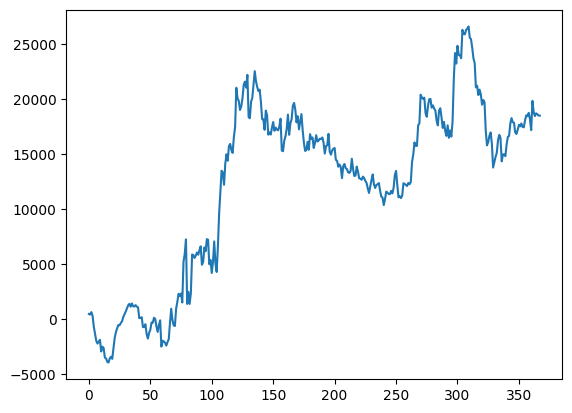

In [65]:
np.cumsum(prof).plot()